# Customer Retention & Segmentation System

### Author: Sushma Yarru  
### Role: Python Developer | Machine Learning Enthusiast  

---

##  Project Overview

This project focuses on predicting customer churn and segmenting customers using machine learning techniques.

The objective is to:
- Identify customers likely to leave
- Estimate potential churn timing
- Segment customers based on behavioral patterns
- Enable targeted retention strategies

This project combines supervised and unsupervised learning to deliver actionable business insights.


## Importing Required Libraries

In this section, we import all necessary Python libraries for:

- Data manipulation (Pandas, NumPy)
- Data visualization (Matplotlib)
- Machine Learning (Scikit-learn)
- Clustering and Dimensionality Reduction (KMeans, PCA)

These libraries form the foundation of the analytics pipeline.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
from sklearn.cluster import KMeans


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA


## Loading the Dataset

We load the Telco Customer Churn dataset, which contains customer demographic information, subscription details, service usage, and churn status.

This dataset will be used to:
- Predict churn probability
- Perform customer segmentation
- Analyze behavioral patterns


In [5]:
df = pd.read_csv("/content/Telco_Cusomer_Churn.csv")

## enhancements -> connecting to a live database
import sqlite3
conn = sqlite3.connect("customer.db")
df = pd.read_sql("SELECT * FROM customers", conn)



In [6]:
df.shape

(7043, 21)

## Data Cleaning & Preprocessing

Before applying machine learning models, we perform data cleaning:

- Remove irrelevant identifiers (customerID)
- Convert TotalCharges to numeric format
- Handle missing values
- Ensure consistent data types

Clean data is critical for accurate model performance and reliable insights.

In [7]:
#removes the column customerID(doesn't have any info as it is unique) from the dataframe.
#inplace=True → modify original dataframe directly
df.drop("customerID", axis=1, inplace=True)

In [8]:
#errors="coerce" -> If conversion fails → replace with NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")


In [9]:
#dropna() -> Removes rows where any column has NaN.
# To ensure clean input data and prevent training errors,
# since tree-based models in scikit-learn do not handle NaN natively
df.dropna(inplace=True)


## Feature Engineering

Feature engineering enhances model performance by creating meaningful variables.

In this section:

- Churn is converted from categorical (Yes/No) to numeric (1/0)
- Recency feature is created based on tenure
- Categorical variables are encoded
- Behavioral indicators are prepared

These transformations help the model better understand customer behavior.

FUTURE UPDATES: A stronger approach would be:

Last login date

Last purchase date

Days since last activity

That would give a real Recency metric.

In [10]:
#df["tenure"].max() -> finds the maximum tenure(longest stayed customer) value in the dataset.
# Recency means -> How recently has a customer been active?
#Low Recency (0–10) → Customer is long-term / loyal
# High Recency (60–71) → Customer is new / recently joined
df["Recency"] = df["tenure"].max() - df["tenure"]


In [11]:
df["AvgMonthlyCharges"] = df["MonthlyCharges"]


In [12]:
#machine learning models do not understand text so we convert them to numbers
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


In [13]:
df["TimeToChurn"] = df["tenure"]


ENCODE CATEGORICAL VARIABLES

In [14]:
#It is used to convert categorical text data into numbers.
le = LabelEncoder()


In [15]:
#This selects all columns that contain text (string) data. because in pandas, text columns are of type object.
#second line does 3 things 1.) selects unique values in column 2.) tranforms into numbers 3.) stores them back to df
for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])


## Feature Scaling

Machine learning models are sensitive to differences in feature scale.

We apply StandardScaler to:
- Normalize numerical features
- Ensure balanced feature contribution
- Improve convergence for distance-based algorithms

Scaling is especially important for clustering (KMeans) and PCA.


In [16]:
seg_features = df[["tenure", "MonthlyCharges", "TotalCharges"]]


In [17]:
#If we don’t scale: TotalCharges has much bigger numbers.
# Model may think it is more important — just because the numbers are large.
# we calculate mean and standard deviation inorder to compare features fairly
#fit() → learns mean & std from training data
# transform() → scales data
scaler = StandardScaler()
seg_scaled = scaler.fit_transform(seg_features)


Customer segmentation

In [18]:
#divides customers into 4 clusters and assigns them with the nearest cluster - Kmeans algo
#random_state=42 -> Your customer segmentation will remain consistent.
kmeans = KMeans(n_clusters=4, random_state=42)


In [19]:
#this is where actual customer segmentation happens. finds clusters and assigns each customer to their nearest cluster.
# fit_predict -> algorithm decides which customers go in which cluster which is saved in segment
df["Segment"] = kmeans.fit_predict(seg_scaled)


## Dimensionality Reduction using PCA

To visualize high-dimensional customer data, we apply Principal Component Analysis (PCA).

PCA reduces multiple features into 2 principal components while retaining maximum variance.

This allows:
- 2D visualization of clusters
- Better interpretability
- Clear understanding of segment separation


In [20]:
#all features in seg_scaled down to 2 new axes.
#This is often done for visualization, because 2D can be plotted easily.
#fit() → Finds the directions (principal components) that explain maximum variance in your data.
#transform() → Projects your data onto these 2 components.
pca = PCA(n_components=2)
pca_components = pca.fit_transform(seg_scaled)


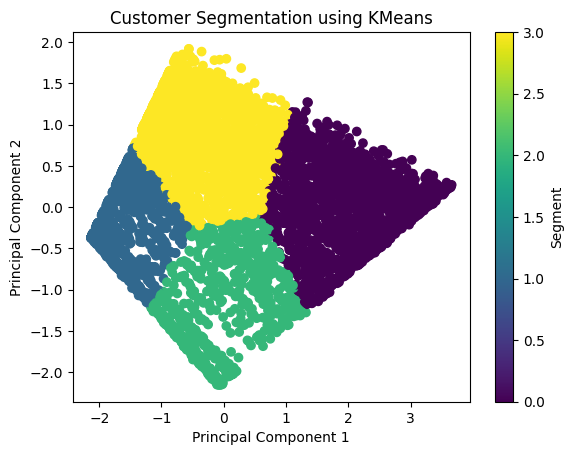

In [21]:
# x-axis and y-axis and c is for differentiating colors

plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df["Segment"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Customer Segmentation using KMeans")
plt.colorbar(label="Segment")
plt.show()

In [ ]:
plt.savefig("cluster_plot.png")

CHURN CLASSIFICATION
## Train-Test Split

The dataset is split into training and testing sets to evaluate model performance.

- Training set → Used to train the model
- Testing set → Used to validate predictions

This prevents data leakage and ensures the model generalizes well to unseen data.


In [23]:
X = df.drop(["Churn", "TimeToChurn"], axis=1)
y = df["Churn"]


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)




In [25]:
print(X.shape)
print(y.shape)


(7032, 22)
(7032,)


## Churn Prediction using Random Forest

We train a RandomForestClassifier to predict customer churn.

Why Random Forest?
- Handles non-linear relationships
- Works well with structured data
- Robust against overfitting
- Requires minimal feature scaling

The model learns patterns from customer behavior to predict churn probability.


In [26]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [27]:
y_pred = clf.predict(X_test)


In [28]:
y_prob = clf.predict_proba(X_test)[:, 1]


In [29]:
roc_auc_score(y_test, y_prob)


np.float64(0.8188612679957137)

In [30]:
importance = pd.Series(clf.feature_importances_, index=X.columns)


TIME-TO-CHURN REGRESSION


In [31]:
reg_df = df[df["Churn"] == 1]


In [32]:
X_reg = reg_df.drop(["Churn", "TimeToChurn"], axis=1)
y_reg = reg_df["TimeToChurn"]

In [33]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [34]:
reg = RandomForestRegressor(random_state=42)

# FIT MODEL (THIS IS WHAT YOU WERE MISSING)
reg.fit(X_train_r, y_train_r)

RandomForestRegressor(random_state=42)

In [35]:
reg.score(X_train_r, y_train_r)

0.9999997988360252

## Business Insights

This system enables organizations to:

- Identify customers at high risk of churn
- Segment customers for personalized engagement
- Develop targeted discount strategies
- Improve customer lifetime value

By combining classification and clustering, this solution provides both predictive and strategic intelligence.


In [36]:
df["Churn_Probability"] = clf.predict_proba(X)[:, 1]


In [37]:
def retention_action(prob):
    if prob > 0.7:
        return "High Risk – Offer Discount"
    elif prob > 0.4:
        return "Medium Risk – Send Engagement Email"
    else:
        return "Low Risk – No Action"


In [38]:
df["Recommended_Action"] = df["Churn_Probability"].apply(retention_action)

In [39]:

print(df[["Segment", "Churn_Probability", "Recommended_Action"]].head(20))

    Segment  Churn_Probability                   Recommended_Action
0         1               0.23                 Low Risk – No Action
1         2               0.01                 Low Risk – No Action
2         1               0.82           High Risk – Offer Discount
3         2               0.03                 Low Risk – No Action
4         3               0.86           High Risk – Offer Discount
5         3               1.00           High Risk – Offer Discount
6         3               0.11                 Low Risk – No Action
7         1               0.15                 Low Risk – No Action
8         3               0.75           High Risk – Offer Discount
9         2               0.00                 Low Risk – No Action
10        1               0.03                 Low Risk – No Action
11        1               0.00                 Low Risk – No Action
12        0               0.12                 Low Risk – No Action
13        0               0.88           High Ri

we combined:

1️⃣ Segmentation → Who are the users?
2️⃣ Classification → Will they leave?
3️⃣ Regression → When will they leave?
4️⃣ Business rules → What should we do?

That’s a full customer intelligence system.

Built an AI-driven customer retention analytics system
## Future Enhancements

Potential improvements include:

- Integration with LLMs for automated retention recommendations
- Real-time churn prediction API deployment
- Dashboard integration for business teams
- Automated campaign optimization

This project can evolve into a full-scale AI-driven retention platform.
